Part 1 - Q3 - LSTM
===

Inspirations:

*  https://www.kaggle.com/code/salls123/simple-lstm-binary-classification
*  https://machinelearningmastery.com/sequence-classification-lstm-recurrent-neural-networks-python-keras/

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

In [2]:
%matplotlib inline
import torch
import torch.nn.functional as F

In [3]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc

In [4]:
import param
import panel as pn
pn.extension()
import datetime as dt
import importlib
from importlib import reload
from tqdm import tqdm

In [5]:
import tensorflow as tf
from keras.models import Sequential
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Embedding,Dense,LSTM,Dropout,Flatten,BatchNormalization,Conv1D,GlobalMaxPooling1D,MaxPooling1D
from keras.optimizers import  SGD
from keras.optimizers import  RMSprop
from keras.regularizers import l2
from keras.optimizers import Adam
from keras import regularizers
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import OneHotEncoder
from keras.preprocessing import sequence
from tensorflow.keras.layers import Bidirectional
from keras.losses import BinaryFocalCrossentropy

2024-05-21 21:48:11.668388: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-21 21:48:18.452801: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-21 21:48:23.755469: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [6]:
import graph as gr
import params as par
import py_lib as lib
reload(gr)
reload(par)
reload(lib)
import graph as gr
import params as par
import py_lib as lib

In [7]:
format_dict = par.create_format_dict()

In [8]:
class NotebookParams(param.Parameterized):
    lambda_multiple          = param.Number(1, bounds=(1,10), doc="lambda Lasso Multiple of 10^x")
    lambda_power             = param.Integer(default=2, bounds=(1,7),doc="lambda Lasso exponent of 10^x")
    lr_multiple              = param.Number(5, bounds=(1,10), doc="Learning Rate Multiple of 10^x")
    lr_power                 = param.Integer(default=3, bounds=(1,9),doc="Learning Rate exponent of 10^x")
    epochs                   = param.Integer(default=2000 ,bounds=(1,2000))
    data_set                 = param.ObjectSelector(default="test",objects=['train', 'validation', 'train + validation', 'test'])
    stand_features           = param.Boolean(False, doc="Whether we want to standardize numerical features")
    use_lasso                = param.Boolean(True)
    use_focal_loss           = param.Boolean(True)
    iter_array               = param.Integer(default=5, bounds=(1,20),doc="How often to save loss and training data, in epochs")
    iter_printing            = param.Integer(default=5, bounds=(1,100),doc="How many epochs between printing")
    add_one_hot_encoded      = param.Boolean(False, doc="Whether to add one hot encoded columns from categorical variables")
    test_size                = param.Number(0.2, bounds=(0.1,0.9), doc="Test size for train_test_split")
    random_state_test_train_split = param.Integer(42)
base = NotebookParams()

# Import Data

In [9]:
# df_heart = pd.read_csv('../data_proj2/ptbdb_train.csv')
df_heart_test = pd.read_csv('../data_proj2/ptbdb_test.csv', header=None)
df_heart_train = pd.read_csv('../data_proj2/ptbdb_train.csv', header=None)

In [10]:
df_heart_train.head(3)

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
0,1.000000,0.730599,0.472859,0.139526,0.000000,0.020507,0.112183,0.162847,0.180941,0.192199,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,1.000000,0.152446,0.011377,0.308305,0.153584,0.096701,0.083049,0.086462,0.105802,0.071672,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.975917,0.693234,0.241399,0.107225,0.098050,0.072248,0.062500,0.054472,0.054472,0.045872,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [11]:
df_heart_train.columns

Index([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,
       ...
       178, 179, 180, 181, 182, 183, 184, 185, 186, 187],
      dtype='int64', length=188)

In [12]:
df_heart_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11641 entries, 0 to 11640
Columns: 188 entries, 0 to 187
dtypes: float64(188)
memory usage: 16.7 MB


In [13]:
n_train_examples = df_heart_train.shape[0]
n_test_examples = df_heart_test.shape[0]
n_total_examples = n_train_examples + n_test_examples
print(f'The test split has {n_test_examples} rows, or {n_test_examples/n_total_examples:.2%} of all examples (which represent {n_total_examples} rows).')

The test split has 2911 rows, or 20.00% of all examples (which represent 14552 rows).


# Features preprocessing

In [14]:
x_train_0, x_test_0, y_train_0, y_test_0, lstm_input = lib.pre_process_ecg(
        df_heart_train,
        label_col_pos=-1,
        test_size=base.test_size,
        random_state=base.random_state_test_train_split,
        split_data=True,
				with_lstm_transfo=True,
)

# Regular LSTM

## Model Building

In [15]:
# Computing the alpha for focal loss
class_weights = y_train_0.value_counts() / len(y_train_0)
class_weights = 1-class_weights
alpha_focal_loss = class_weights.loc[1.0].values[0]

In [16]:
def build_model(
	n_neurons=12,
	learning_rate=0.001,
	lstm_dropout=0.7,
	recurrent_dropout = 0.7,
	final_dropout = 0.2,
	clipnorm=0.5,
	use_focal=False,
	use_bidirectional=False,
	use_sgd_opt=False,
	use_rms_loss=False,
	alpha_focal_loss=0.25,
):
	if use_sgd_opt:
		opt = SGD(learning_rate=learning_rate, clipnorm=clipnorm)
	elif use_rms_loss:
		opt = RMSprop(learning_rate=learning_rate, clipnorm=clipnorm)
	else:
		opt = Adam(learning_rate=learning_rate)

	model = Sequential()
	if use_bidirectional:
		model.add(Bidirectional(LSTM(n_neurons, dropout=lstm_dropout, recurrent_dropout=recurrent_dropout)))
	else:
		model.add(LSTM(n_neurons, dropout=lstm_dropout, recurrent_dropout=recurrent_dropout))
	# model.add(Dense(6, kernel_regularizer=regularizers.l1_l2(0.3)))
	model.add(Dropout(final_dropout))
	model.add(Dense(1, activation='sigmoid'))
	if use_focal:
		model.compile(loss=BinaryFocalCrossentropy(alpha=alpha_focal_loss), optimizer=opt, metrics=['accuracy'])
	else:
		model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
	print(model.summary())
	return model

In [18]:
model_lstm=build_model(
	n_neurons=186,
	learning_rate=0.01,
	use_focal=True,
	use_bidirectional=False,
	lstm_dropout=0.3,
	recurrent_dropout = 0.3,
	final_dropout = 0.3,
	clipnorm = 0.5,
	use_sgd_opt=False,
	use_rms_loss=True,
	alpha_focal_loss=alpha_focal_loss,
    )

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

None


## Training

In [20]:
from keras.callbacks import ReduceLROnPlateau
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)

In [21]:
es = EarlyStopping(monitor='val_loss', mode='min',patience=5)
history_lstm = model_lstm.fit(
	lstm_input['x_train'],
	lstm_input['y_train'],
	epochs=18,
	batch_size=64,
	validation_data=(lstm_input['x_test'], lstm_input['y_test']),
	callbacks = [learning_rate_reduction],
	shuffle=False,
    )


Epoch 1/18
146/146 ━━━━━━━━━━━━━━━━━━━━ 106s 708ms/step - accuracy: 0.7005 - loss: 0.1580 - val_accuracy: 0.7201 - val_loss: 0.1597 - learning_rate: 0.0100
Epoch 2/18
146/146 ━━━━━━━━━━━━━━━━━━━━ 99s 679ms/step - accuracy: 0.7188 - loss: 0.1520 - val_accuracy: 0.7201 - val_loss: 0.1560 - learning_rate: 0.0100
Epoch 3/18
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 754ms/step - accuracy: 0.7190 - loss: 0.1516
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0029999999329447745.
146/146 ━━━━━━━━━━━━━━━━━━━━ 120s 821ms/step - accuracy: 0.7191 - loss: 0.1516 - val_accuracy: 0.7201 - val_loss: 0.1553 - learning_rate: 0.0100
Epoch 4/18
146/146 ━━━━━━━━━━━━━━━━━━━━ 106s 725ms/step - accuracy: 0.7191 - loss: 0.1518 - val_accuracy: 0.7201 - val_loss: 0.1512 - learning_rate: 0.0030
Epoch 5/18
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 582ms/step - accuracy: 0.7190 - loss: 0.1511
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0009000000078231095.
146/146 ━━━━━━━━━━━━━━━━━━━━ 92s 628ms/step - accuracy: 0.71

In [ ]:
lib.custom_model_summary(model_lstm)

In [ ]:
y_pred = model_lstm.predict(lstm_input_eval['x_train'])
print(type(y_pred))

91/91 ━━━━━━━━━━━━━━━━━━━━ 16s 164ms/step
<class 'numpy.ndarray'>


In [ ]:
y_pred_df = pd.DataFrame(y_pred.round())
y_pred_df.value_counts()

0  
1.0    2911
Name: count, dtype: int64

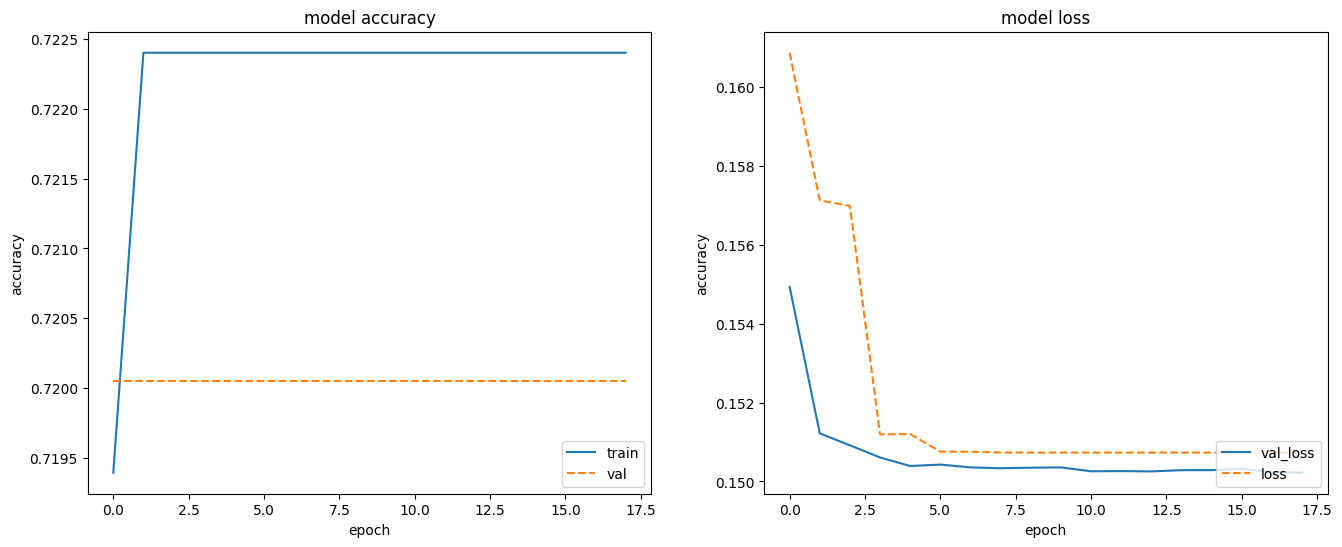

In [ ]:
fig, axes = plt.subplots(1, 2, figsize = (16,6))
axes[0].plot(history_lstm.history['accuracy'])
axes[0].plot(history_lstm.history['val_accuracy'],'--')
axes[0].set_title('model accuracy')
axes[0].set_ylabel('accuracy')
axes[0].set_xlabel('epoch')
axes[0].legend(['train', 'val'], loc='lower right')

axes[1].plot(history_lstm.history['loss'])
axes[1].plot(history_lstm.history['val_loss'],"--")
axes[1].set_title('model loss')
axes[1].set_ylabel('accuracy')
axes[1].set_xlabel('epoch')
axes[1].legend(['val_loss', 'loss'], loc='lower right')

## Evaluation

In [ ]:
_, _, _, _, lstm_input_eval = lib.pre_process_ecg(
        df_heart_test,
        label_col_pos=-1,
        test_size=base.test_size,
        random_state=base.random_state_test_train_split,
        split_data=False,
				with_lstm_transfo=True,
)

In [ ]:
y_pred = model_lstm.predict(lstm_input_eval['x_train'])
print(type(y_pred))

91/91 ━━━━━━━━━━━━━━━━━━━━ 10s 102ms/step
<class 'numpy.ndarray'>


In [ ]:
y_pred_df = pd.DataFrame(y_pred)
y_pred_df.head()

,0
0,0.779923
1,0.779923
2,0.779923
3,0.779923
4,0.779923


In [ ]:
y_pred_tensor, y_pred_round, y_pred_round_tensor = lib.process_for_eval_from_single_proba_array(y_pred)
y_true = torch.from_numpy(lstm_input_eval['y_train'])

In [ ]:
summary_metrics = lib.compute_performance_metrics(y_true, y_pred_round)
summary_metrics.style.format(format_dict)

In [ ]:
from torchmetrics.classification import BinaryF1Score
from sklearn.metrics import accuracy_score, balanced_accuracy_score
acc = accuracy_score(y_true, y_pred_round, normalize = True)  
bal_acc=balanced_accuracy_score(y_true, y_pred_round)
f1_score = BinaryF1Score()
f1 = f1_score(y_pred_round_tensor, y_true).numpy()
summary_metrics = pd.DataFrame(data=[acc, bal_acc, f1], index=['Accuracy', 'Balanced Accuracy', 'F1 Score'], columns=['metrics']).T

In [92]:
summary_metrics.style.format(format_dict)

,Accuracy,Balanced Accuracy,F1 Score
metrics,72.2%,50.0%,83.9%


Text(0.5, 1.0, 'Confusion Matrix, dataset = test')

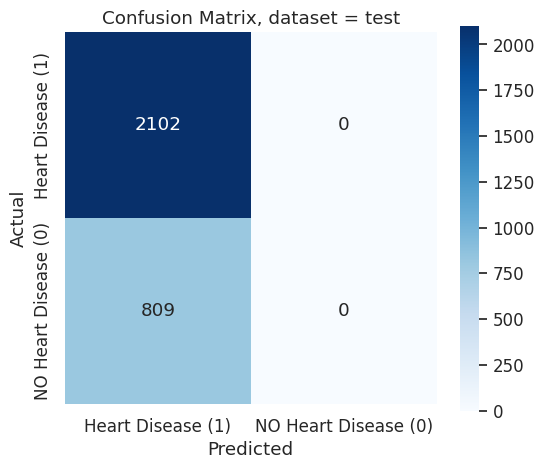

In [93]:
logreg_conf_matrix = confusion_matrix(y_true, y_pred_round)
plt.figure(figsize = (6,5)) 
sns.set(font_scale=1.1) 
ax = sns.heatmap(
    logreg_conf_matrix,
    cmap='Blues',
    annot=True,
    fmt='d',
    square=True,
    xticklabels=['NO Heart Disease (0)', 'Heart Disease (1)'],
    yticklabels=['NO Heart Disease (0)', 'Heart Disease (1)'])
ax.set(xlabel='Predicted', ylabel='Actual')
ax.invert_yaxis()
ax.invert_xaxis()
ax.set_title('Confusion Matrix, dataset = {}'.format(base.data_set))

In [94]:
fpr, tpr, thresholds = roc_curve(y_true, y_pred)
auc_performance = auc(fpr, tpr)

In [95]:
import graph as gr
reload(gr)
import graph as gr

/home/pinolej/eth/healthcare/proj3/task_1/graph.py:303: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(['{:,.0%}'.format(x) for x in vals], fontsize=9)
/home/pinolej/eth/healthcare/proj3/task_1/graph.py:305: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['{:,.0%}'.format(x) for x in vals], fontsize=9)


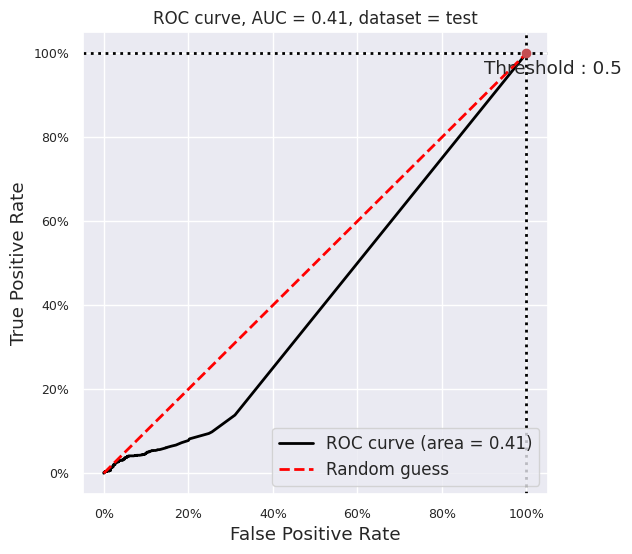

In [96]:
gr.custom_roc_curve(
        fpr,
        tpr,
        thresholds,
        thresholds_to_plot=[0.5],
        figsize=(6,6),
        fontsize={
            'ax_title': 12,
        },
        dataset_type=base.data_set,
        auc_performance=auc_performance,
        y_text_margin=0.05,
        x_text_margin=0.1,
        plot_threshold=True,
)

# Bidirectional LSTM

## Model Building

In [54]:
bi_model_lstm=build_model(
	n_neurons=186,
	learning_rate=0.05,
	use_focal=True,
	use_bidirectional=False,
	lstm_dropout=0.7,
	recurrent_dropout = 0.7,
	final_dropout = 0.7,
	clipnorm = 0.5,
	use_sgd_opt=True,
	use_rms_loss=False,
    )

In [ ]:
lib.custom_model_summary(bi_model_lstm)

## Training

In [56]:
es = EarlyStopping(monitor='val_loss', mode='min',patience=5)
bi_history_lstm = bi_model_lstm.fit(
	lstm_input['x_train'],
	lstm_input['y_train'],
	epochs=3,
	batch_size=300,
	validation_data=(lstm_input['x_test'], lstm_input['y_test']),
	shuffle=False
    )



Epoch 1/3
32/32 ━━━━━━━━━━━━━━━━━━━━ 26s 557ms/step - accuracy: 0.6116 - loss: 0.6732 - val_accuracy: 0.7201 - val_loss: 0.6252
Epoch 2/3
32/32 ━━━━━━━━━━━━━━━━━━━━ 16s 511ms/step - accuracy: 0.7112 - loss: 0.6308 - val_accuracy: 0.7201 - val_loss: 0.5889
Epoch 3/3
32/32 ━━━━━━━━━━━━━━━━━━━━ 19s 580ms/step - accuracy: 0.7182 - loss: 0.6138 - val_accuracy: 0.7201 - val_loss: 0.5865


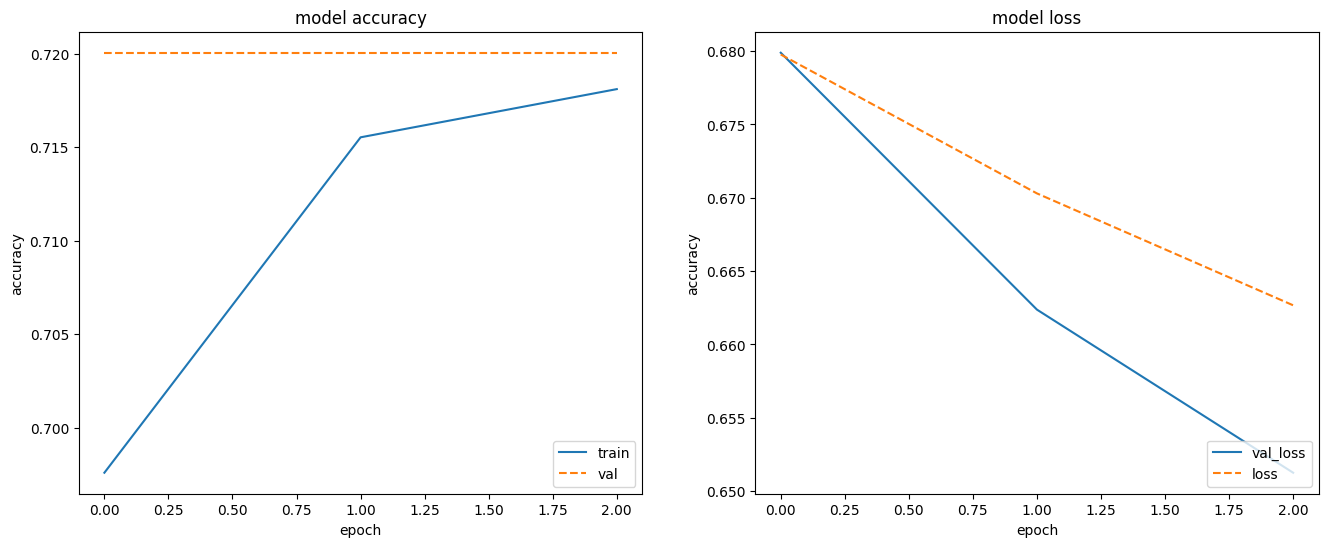

In [ ]:
fig, axes = plt.subplots(1, 2, figsize = (16,6))
axes[0].plot(bi_history_lstm.history['accuracy'])
axes[0].plot(bi_history_lstm.history['val_accuracy'],'--')
axes[0].set_title('model accuracy')
axes[0].set_ylabel('accuracy')
axes[0].set_xlabel('epoch')
axes[0].legend(['train', 'val'], loc='lower right')

axes[1].plot(bi_history_lstm.history['loss'])
axes[1].plot(bi_history_lstm.history['val_loss'],"--")
axes[1].set_title('model loss')
axes[1].set_ylabel('accuracy')
axes[1].set_xlabel('epoch')
axes[1].legend(['val_loss', 'loss'], loc='lower right')

## Evaluation

In [57]:
_, _, _, _, lstm_input_eval = lib.pre_process_ecg(
        df_heart_test,
        label_col_pos=-1,
        test_size=base.test_size,
        random_state=base.random_state_test_train_split,
        split_data=False,
				with_lstm_transfo=True,
)

In [58]:
y_pred = bi_model_lstm.predict(lstm_input_eval['x_train'])
print(type(y_pred))

91/91 ━━━━━━━━━━━━━━━━━━━━ 11s 109ms/step
<class 'numpy.ndarray'>


In [59]:
y_pred_df = pd.DataFrame(y_pred)
y_pred_df.head(3)

,0
0,0.704464
1,0.687560
2,0.693312
3,0.721168
4,0.706617


In [60]:
y_pred_df.value_counts()

0       
0.733979    2
0.732700    2
0.721169    2
0.686956    2
0.698354    2
           ..
0.690756    1
0.690780    1
0.690783    1
0.690783    1
0.743538    1
Name: count, Length: 2906, dtype: int64

In [ ]:
y_pred_tensor, y_pred_round, y_pred_round_tensor = lib.process_for_eval_from_single_proba_array(y_pred)
y_true = torch.from_numpy(lstm_input_eval['y_train'])

In [ ]:
summary_metrics = lib.compute_performance_metrics(y_true, y_pred_round)
summary_metrics.style.format(format_dict)

In [ ]:
from torchmetrics.classification import BinaryF1Score
from sklearn.metrics import accuracy_score, balanced_accuracy_score
acc = accuracy_score(y_true, y_pred_round, normalize = True)  
bal_acc=balanced_accuracy_score(y_true, y_pred_round)
f1_score = BinaryF1Score()
f1 = f1_score(y_pred_round_tensor, y_true).numpy()
summary_metrics = pd.DataFrame(data=[acc, bal_acc, f1], index=['Accuracy', 'Balanced Accuracy', 'F1 Score'], columns=['metrics']).T

In [ ]:
summary_metrics.style.format(format_dict)

,Accuracy,Balanced Accuracy,F1 Score
metrics,72.2%,50.0%,83.9%


Text(0.5, 1.0, 'Confusion Matrix, dataset = test')

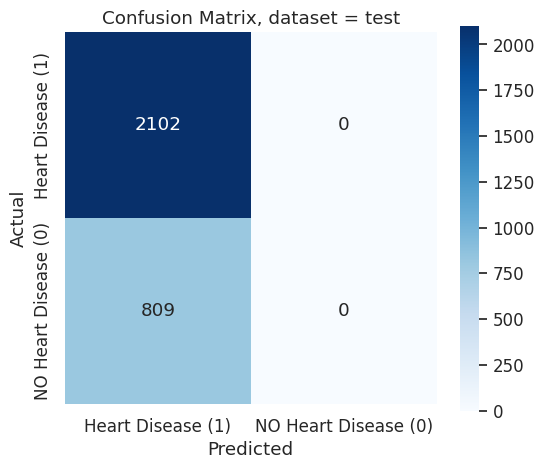

In [ ]:
logreg_conf_matrix = confusion_matrix(y_true, y_pred_round)
plt.figure(figsize = (6,5)) 
sns.set(font_scale=1.1) 
ax = sns.heatmap(
    logreg_conf_matrix,
    cmap='Blues',
    annot=True,
    fmt='d',
    square=True,
    xticklabels=['NO Heart Disease (0)', 'Heart Disease (1)'],
    yticklabels=['NO Heart Disease (0)', 'Heart Disease (1)'])
ax.set(xlabel='Predicted', ylabel='Actual')
ax.invert_yaxis()
ax.invert_xaxis()
ax.set_title('Confusion Matrix, dataset = {}'.format(base.data_set))

In [ ]:
fpr, tpr, thresholds = roc_curve(y_true, y_pred)
auc_performance = auc(fpr, tpr)

In [ ]:
import graph as gr
reload(gr)
import graph as gr

/home/pinolej/eth/healthcare/proj3/task_1/graph.py:303: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(['{:,.0%}'.format(x) for x in vals], fontsize=9)
/home/pinolej/eth/healthcare/proj3/task_1/graph.py:305: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['{:,.0%}'.format(x) for x in vals], fontsize=9)


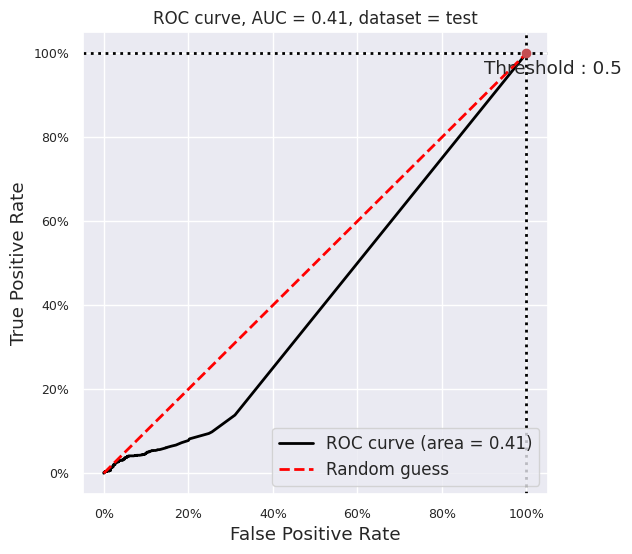

In [ ]:
gr.custom_roc_curve(
        fpr,
        tpr,
        thresholds,
        thresholds_to_plot=[0.5],
        figsize=(6,6),
        fontsize={
            'ax_title': 12,
        },
        dataset_type=base.data_set,
        auc_performance=auc_performance,
        y_text_margin=0.05,
        x_text_margin=0.1,
        plot_threshold=True,
)

/home/pinolej/eth/healthcare/proj3/task_1/graph.py:303: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(['{:,.0%}'.format(x) for x in vals], fontsize=9)
/home/pinolej/eth/healthcare/proj3/task_1/graph.py:305: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['{:,.0%}'.format(x) for x in vals], fontsize=9)


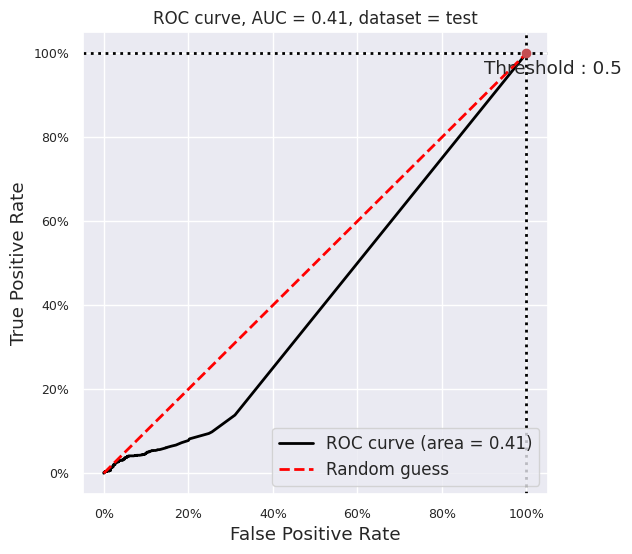

In [ ]:
gr.custom_roc_curve(
        fpr,
        tpr,
        thresholds,
        thresholds_to_plot=[0.5],
        figsize=(6,6),
        fontsize={
            'ax_title': 12,
        },
        dataset_type=base.data_set,
        auc_performance=auc_performance,
        y_text_margin=0.05,
        x_text_margin=0.1,
        plot_threshold=True,
)